In [1]:
# import libraries
import pandas as pd
from datetime import timedelta
from datetime import datetime
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# import train and test data
train = pd.read_csv("train_MpHjUjU.csv")
test = pd.read_csv("test_hXY9mYw.csv")

In [3]:
# checkout train data and features available
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [4]:
# checkout test data
test.head()

,Emp_ID
0,394
1,173
2,1090
3,840
4,308


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [6]:
# total number of unique employees in train data (which includes number of employees for test also)
train.Emp_ID.map(str).nunique()

2381

In [7]:
# total number of employees for prediction
test.Emp_ID.map(str).nunique()

741

In [8]:
# Let us split all input data in 2 dataframes - one for training model and other for prediction
test_df = train[train['Emp_ID'].isin(test['Emp_ID'])]
train_df = train.drop(test_df.index)

In [9]:
# total number of unique employees in train data excluding number of employees to be predicted
train_df.Emp_ID.map(str).nunique()

1640

In [10]:
# train data before preprocessing
train_df

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
5,2016-12-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
6,2017-01-01,4,43,Male,C13,Master,65603,2016-12-07,NaN,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19092,2016-02-01,2787,28,Female,C20,Master,69498,2015-07-21,NaN,1,1,250000,2
19093,2016-03-01,2787,28,Female,C20,Master,69498,2015-07-21,NaN,1,1,319740,2
19094,2016-04-01,2787,28,Female,C20,Master,69498,2015-07-21,NaN,1,1,0,1
19095,2016-05-01,2787,28,Female,C20,Master,69498,2015-07-21,NaN,1,1,0,1


In [11]:
# test data before preprocessing
test_df

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
13,2017-08-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,1
14,2017-09-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,1
15,2017-10-01,6,31,Female,C11,Bachelor,78728,2017-07-31,NaN,3,3,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19099,2017-08-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,740280,3
19100,2017-09-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,448370,3
19101,2017-10-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,0,2
19102,2017-11-01,2788,30,Male,C27,Master,70254,2017-06-08,NaN,2,2,200420,2


#### Since our data contains records for employees month-wise. This data has multiple entries for employees. We need to prepare data for model training using ***groupby*** function so that final data has a unique entry for each employee and all important features are aggregated. We will also see if new features should be created for better training of our model.

In [12]:
# Checking if a employee has worked in more than one city. (Answer: no)
train_df.groupby(['Emp_ID'])['City'].nunique().sum()

1640

In [13]:
# Checking if a employee's Education_Level changed. e.g. completed higher study and employee changed job for better prospects. (Answer: no)
train_df.groupby(['Emp_ID'])['Education_Level'].nunique().sum()

1640

In [14]:
'''Checking if a employee got increment. (Answer: yes, 3 employees).
Since proportion of employees who got salary hike (3/1640) is very small so we will exclude this 
feature from our model for now and will keep only last salary in model.'''
# train_df.groupby(['Emp_ID'])['Salary'].nunique()[train_df.groupby(['Emp_ID'])['Salary'].nunique()>1]
# train_df.groupby(['Emp_ID'])['Salary'].nunique().sum()
train_df.groupby(['Emp_ID'])['Salary'].nunique().map(lambda x: x-1).sum()

3

#### We will use number of working days (tenure) of employees who have already resigned in our model and drop "Dateofjoining" and "LastWorkingDate" from our data for training of model.

In [15]:
'''Checking if a employee was promoted during job since some employees tend to switch job immediately after promotion for better 
prospects. (Answer: 3 employees were promoted).
Since proportion of employees promoted (3/1640) is very small so we will exclude this feature from our model for now and will 
keep only last designation in model.'''
# train_df.groupby(['Emp_ID'])['Designation'].nunique().sum()
train_df.groupby(['Emp_ID'])['Designation'].nunique().map(lambda x: x-1).sum()

3

#### We will consider monthly average of "Total Business Value" by each employee in our model. We will also create 3 new features -  (1) last month business value, (2) whether any month with negative business and (3) whether any month with zero business  for each employee in our model

In [16]:
# It seems many employees have more than 1 "Quarterly Rating" during tenure. so we will keep average of "Quarterly Rating".

train_df.groupby(['Emp_ID'])['Quarterly Rating'].nunique().map(lambda x: x-1).sum()

864

In [17]:
# Let us now apply groupby to aggregate train data
train_grouped = train_df.groupby(['Emp_ID'])
function_dict = {"MMM-YY": "first", "Age": "last", "Gender": "last", "City": "last", "Education_Level": "last", "Salary":"last", "Dateofjoining":"first", "LastWorkingDate":"last", "Designation":"last", "Total Business Value": "mean", "Quarterly Rating":"mean"}
train_grouped = train_grouped.aggregate(function_dict)
train_grouped

,MMM-YY,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Designation,Total Business Value,Quarterly Rating
Emp_ID,,,,,,,,,,,
1,2016-01-01,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,571860.000000,2.000000
4,2016-12-01,43,Male,C13,Master,65603,2016-12-07,2017-04-27,2,70000.000000,1.000000
5,2016-01-01,29,Male,C9,College,46368,2016-01-09,2016-03-07,1,40120.000000,1.000000
8,2017-09-01,34,Male,C2,College,70656,2017-09-19,2017-11-15,3,0.000000,1.000000
12,2016-07-01,35,Male,C23,Master,28116,2016-06-29,2016-12-21,1,434530.000000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...
2779,2017-01-01,28,Male,C26,College,95133,2017-01-26,2017-02-14,3,0.000000,1.000000
2782,2016-05-01,26,Male,C19,Bachelor,29582,2016-05-16,2016-08-16,1,0.000000,1.000000
2785,2017-08-01,34,Female,C9,College,12105,2017-08-28,2017-10-28,1,0.000000,1.000000


In [18]:
train_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 1 to 2787
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MMM-YY                1640 non-null   object 
 1   Age                   1640 non-null   int64  
 2   Gender                1640 non-null   object 
 3   City                  1640 non-null   object 
 4   Education_Level       1640 non-null   object 
 5   Salary                1640 non-null   int64  
 6   Dateofjoining         1640 non-null   object 
 7   LastWorkingDate       1616 non-null   object 
 8   Designation           1640 non-null   int64  
 9   Total Business Value  1640 non-null   float64
 10  Quarterly Rating      1640 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 153.8+ KB


In [19]:
# Let us convert 2 dates columns with string data type to datetime type to calculate tenure for each employee
train_grouped['Dateofjoining'] = pd.to_datetime(train_grouped['Dateofjoining'], format='%Y-%m-%d')
train_grouped['LastWorkingDate'] = pd.to_datetime(train_grouped['LastWorkingDate'], format='%Y-%m-%d')
train_grouped['tenure_days']=(train_grouped['LastWorkingDate']-train_grouped['Dateofjoining']).map(lambda x: x.days)

In [20]:
# Now let us drop 3 columns which are not needed for model training
train_grouped = train_grouped.drop(['MMM-YY','Dateofjoining','LastWorkingDate'],axis=1)

# Now drop employees who had not left organization during 2016 and 2017 i.e. tenure_days = Null
train_grouped_final = train_grouped[train_grouped['tenure_days'].notna()]
train_grouped_final

,Age,Gender,City,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating,tenure_days
Emp_ID,,,,,,,,,
1,28,Male,C23,Master,57387,1,571860.000000,2.000000,78.0
4,43,Male,C13,Master,65603,2,70000.000000,1.000000,141.0
5,29,Male,C9,College,46368,1,40120.000000,1.000000,58.0
8,34,Male,C2,College,70656,3,0.000000,1.000000,57.0
12,35,Male,C23,Master,28116,1,434530.000000,2.500000,175.0
...,...,...,...,...,...,...,...,...,...
2779,28,Male,C26,College,95133,3,0.000000,1.000000,19.0
2782,26,Male,C19,Bachelor,29582,1,0.000000,1.000000,92.0
2785,34,Female,C9,College,12105,1,0.000000,1.000000,61.0


In [21]:
# Now let us preprocess test data also to align it with our final train data
test_grouped = test_df.groupby(['Emp_ID'])
function_dict = {"MMM-YY": "first", "Age": "last", "Gender": "last", "City": "last", "Education_Level": "last", "Salary":"last", "Dateofjoining":"first", "LastWorkingDate":"last", "Designation":"last", "Total Business Value": "mean", "Quarterly Rating":"mean"}
test_grouped = test_grouped.aggregate(function_dict)

# Now let us drop columns which are not needed for model prediction
test_grouped_final = test_grouped.drop(['MMM-YY','Dateofjoining','LastWorkingDate'],axis=1)
test_grouped_final

,Age,Gender,City,Education_Level,Salary,Designation,Total Business Value,Quarterly Rating
Emp_ID,,,,,,,,
2,31,Male,C7,Master,67016,2,0.000000e+00,1.000000
6,31,Female,C11,Bachelor,78728,3,2.530000e+05,1.600000
11,28,Female,C19,Master,42172,1,0.000000e+00,1.000000
14,39,Female,C26,College,19734,3,0.000000e+00,1.000000
25,31,Male,C24,Bachelor,102077,3,1.514630e+06,3.750000
...,...,...,...,...,...,...,...,...
2775,27,Male,C9,College,85112,3,0.000000e+00,1.000000
2778,35,Male,C13,Master,50180,2,0.000000e+00,1.000000
2781,25,Male,C23,Master,46952,2,7.848518e+05,3.181818


In [22]:
# Now we will create dummy variables from categorical variables in train/ test data for model training/ testing
train_grouped_final = pd.get_dummies(train_grouped_final)

test_grouped_final = pd.get_dummies(test_grouped_final)
train_temp, test_grouped_final = train_grouped_final.drop(['tenure_days'],axis=1).align(test_grouped_final, join='left', axis=1)

In [23]:
# final glance at train data before model training
train_grouped_final

,Age,Salary,Designation,Total Business Value,Quarterly Rating,tenure_days,Gender_Female,Gender_Male,City_C1,City_C10,...,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_Bachelor,Education_Level_College,Education_Level_Master
Emp_ID,,,,,,,,,,,,,,,,,,,,,
1,28,57387,1,571860.000000,2.000000,78.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,43,65603,2,70000.000000,1.000000,141.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,29,46368,1,40120.000000,1.000000,58.0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
8,34,70656,3,0.000000,1.000000,57.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
12,35,28116,1,434530.000000,2.500000,175.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2779,28,95133,3,0.000000,1.000000,19.0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2782,26,29582,1,0.000000,1.000000,92.0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2785,34,12105,1,0.000000,1.000000,61.0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [24]:
# final glance at test data
test_grouped_final

,Age,Salary,Designation,Total Business Value,Quarterly Rating,Gender_Female,Gender_Male,City_C1,City_C10,City_C11,...,City_C3,City_C4,City_C5,City_C6,City_C7,City_C8,City_C9,Education_Level_Bachelor,Education_Level_College,Education_Level_Master
Emp_ID,,,,,,,,,,,,,,,,,,,,,
2,31,67016,2,0.000000e+00,1.000000,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,31,78728,3,2.530000e+05,1.600000,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
11,28,42172,1,0.000000e+00,1.000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,39,19734,3,0.000000e+00,1.000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
25,31,102077,3,1.514630e+06,3.750000,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2775,27,85112,3,0.000000e+00,1.000000,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2778,35,50180,2,0.000000e+00,1.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2781,25,46952,2,7.848518e+05,3.181818,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
## Grid search to find best params automatically

train_data_X = train_grouped_final.drop('tenure_days', 1)
train_data_y = train_grouped_final['tenure_days']

scikit_model = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [8, 12, 16, 24, 32, 40, 48],
    'max_depth': [2, 3, 4, 5]
}
nfold = 5

grid_search = GridSearchCV(scikit_model, param_grid, cv=5, return_train_score=True, refit=True)
grid_search.fit(train_data_X, train_data_y)
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,0.046870,0.000005,0.006253,0.007658,2,16,"{'max_depth': 2, 'n_estimators': 16}",0.323079,0.453931,0.491652,...,0.421479,0.061401,1,0.539425,0.514463,0.509278,0.526142,0.515598,0.520981,0.010726
1,0.037494,0.007658,0.006254,0.007659,2,12,"{'max_depth': 2, 'n_estimators': 12}",0.330655,0.447235,0.494031,...,0.420124,0.057644,2,0.527470,0.504558,0.481112,0.513871,0.494371,0.504277,0.015905
3,0.052845,0.007335,0.012508,0.006254,2,24,"{'max_depth': 2, 'n_estimators': 24}",0.331799,0.451682,0.490925,...,0.418256,0.059434,3,0.563306,0.539339,0.538106,0.550146,0.535123,0.545204,0.010378
5,0.074996,0.006251,0.012500,0.006250,2,40,"{'max_depth': 2, 'n_estimators': 40}",0.315341,0.452279,0.469483,...,0.413819,0.058739,4,0.604179,0.581130,0.582896,0.592641,0.576057,0.587380,0.009973
0,0.035997,0.009500,0.011381,0.006094,2,8,"{'max_depth': 2, 'n_estimators': 8}",0.346324,0.437149,0.490493,...,0.412585,0.055704,5,0.502250,0.477022,0.460012,0.487179,0.466706,0.478634,0.014983


In [26]:
# When refit=True was used it's super easy to get best estimator from grid search
best_estimator = grid_search.best_estimator_
best_estimator

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=16, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

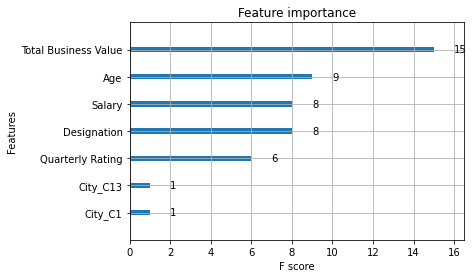

In [27]:
xgb.plot_importance(best_estimator)

In [28]:
# do some predictions
estimations = best_estimator.predict(test_grouped_final)

In [30]:
submission = pd.DataFrame({'Emp_ID':test_grouped_final.index, 'Dateofjoining':test_grouped['Dateofjoining'], 'tenure_days': estimations})
submission['Dateofjoining'] = pd.to_datetime(submission['Dateofjoining'], format='%Y-%m-%d')
submission['predicted_last_day'] = submission['Dateofjoining'] + pd.to_timedelta(submission['tenure_days'].astype('int'),'d')

start_date_range = datetime.strptime('2018-01-01', '%Y-%m-%d')
end_date_range = datetime.strptime('2018-07-01', '%Y-%m-%d')
submission['Target']=submission['predicted_last_day'].apply(lambda x: 1 if x >=start_date_range and x <=end_date_range else 0)

In [31]:
submission=submission[['Emp_ID', 'Target']]
submission.to_csv(f"submission_{time.strftime('%Y%m%d_%H%M')}.csv",index=False)